# Описание проекта
Заказчик решает открыть небольшое кафе в Москве, в основе деятельности которого обслуживание клиентов роботами. Проект дорогой и требует участия инвесторов. Инвесторы просят описать текущее положение дел на рынке, обосновать долговременный характер проекта: будет ли спрос на кафе, когда любопытство случайных посетителей уже будет удовлетворено? 

# Доступные данные:
В нашем распоряжении имеются открытые данные о заведениях общественного питания Москвы. Таблица rest_data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

# Цели проекта:
- Выполнить анализ данных,
- Подготовить презентацию исследования для инвесторов.

# Содержание

1. Изучение и подготовка данных из файлов
2. Анализ данных
3. Выводы и рекомендации

# 1. Изучение и подготовка данных из файлов <a class="anchor" id="first-bullet"></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from numpy import median
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import stats as st
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', -1)

Открываем файлы:

In [2]:
try:
    rest_data = pd.read_csv('rest_data.csv')
except:
    rest_data = pd.read_csv('/datasets/rest_data.csv')

Предпросмотр файла:

In [3]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Проверим на полные дубликаты:

In [4]:
duplicates = rest_data[rest_data.duplicated(keep='last')]
print(duplicates)

Empty DataFrame
Columns: [id, object_name, chain, object_type, address, number]
Index: []


Полные дубликаты отсутствуют.

Проверим, нет ли дублирующихся по смыслу категорий объектов:

In [5]:
print(rest_data['object_type'].unique())

['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']


Как видим, категории объектов уникальны.

Проверим на наличие одинаковых заведений по адресу:

In [6]:
dupl_name = rest_data[rest_data[['object_name','address']].duplicated()]
dupl_name.head()

,id,object_name,chain,object_type,address,number
114,28613,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,закусочная,"город Москва, Бригадирский переулок, дом 3-5",216
115,28614,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
579,149227,Общественное питание,нет,столовая,"город Москва, Павелецкая площадь, дом 1",70
580,149205,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39


In [7]:
print("Количество дублирующихся заведений по адресу:",dupl_name.shape[0])

Количество дублирующихся заведений по адресу: 207


Такие дубликаты есть, их количество 207. Вероятно, какие-то заведение прошли перерегистрацию в качестве другой категории объекта, а записи о старой категории не удалили. Предлагаем оставить те из них, у которых id будет с большим номером, т.к. более новые сведения. Выделим список старых id:

In [8]:
new_ids = dupl_name.groupby('object_name')['id'].max().reset_index()['id']
new_ids.shape[0]

87

In [9]:
old_ids = rest_data[~rest_data['id'].isin(new_ids)].reset_index()['id']
old_ids.shape[0]

15279

In [10]:
rest_data = rest_data.loc[rest_data['id'].isin(old_ids)]
rest_data.shape

(15279, 6)

Дубликаты удалены.

Для лучшей читаемости на графиках заменим сочетание "предприятие быстрого обслуживания" на "экспресс", "магазин (отдел кулинарии)" на "кулинария":

In [11]:
rest_data['object_type'] = rest_data['object_type'].replace(
    {'магазин (отдел кулинарии)':'кулинария', 'предприятие быстрого обслуживания':'экспресс'})

Проверим качественный и количественный состав данных:

In [12]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15279 entries, 0 to 15364
Data columns (total 6 columns):
id             15279 non-null int64
object_name    15279 non-null object
chain          15279 non-null object
object_type    15279 non-null object
address        15279 non-null object
number         15279 non-null int64
dtypes: int64(2), object(4)
memory usage: 835.6+ KB


Как видим, пропусков нет, типы данных верны.

Поссмотрим на цифровые показатели по количеству мест:

In [13]:
rest_data['number'].describe()

count    15279.000000
mean     59.686891   
std      74.852279   
min      0.000000    
25%      13.000000   
50%      40.000000   
75%      80.000000   
max      1700.000000 
Name: number, dtype: float64

Ничего подозрительного не видно.

**На этом подготовка данных завершена**

# 2. Анализ данных <a class="anchor" id="second-bullet"></a>

**Задачи:**
- Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.
- Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.
- Для какого вида объекта общественного питания характерно сетевое распространение?
- Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
- Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.
- Выделите в отдельный столбец информацию об улице из столбца address .
- Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
- Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
- Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

### Соотношение видов объектов общественного питания по количеству:

In [14]:
rest_data_group_by_type = rest_data.groupby('object_type')['id'].nunique().reset_index().sort_values(by='id', ascending=False)
print(rest_data_group_by_type)

  object_type    id
3  кафе        6062
7  столовая    2579
6  ресторан    2276
8  экспресс    1909
0  бар         852 
1  буфет       577 
4  кафетерий   396 
2  закусочная  356 
5  кулинария   272 


Соотношение будет показательно на круговой и столбчатой диаграмме:

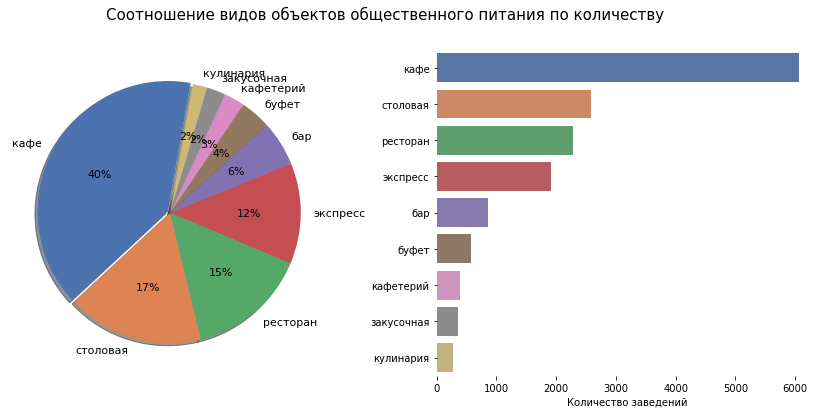

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))

fig.suptitle('Соотношение видов объектов общественного питания по количеству',fontsize=15)
data = rest_data_group_by_type['id']
labels = rest_data_group_by_type['object_type']
explode = (0.02, 0, 0, 0, 0, 0, 0, 0, 0)
colors = sns.color_palette('deep')[0:9]
ax1.pie(data, 
        labels = labels, 
        colors = colors, 
        autopct='%.0f%%', 
        startangle=80, 
        explode=explode, 
        shadow=True,
       textprops={'fontsize': 11})

ax2 = sns.barplot(x='id', y='object_type', 
                  data=rest_data_group_by_type.sort_values(by='id', ascending=False), palette="deep")

plt.xlabel('Количество заведений')
plt.ylabel('')
plt.box(False)

plt.show()

### Соотношение сетевых и несетевых заведений по количеству

In [17]:
rest_data_group_by_chain = rest_data.groupby('chain')['id'].nunique().reset_index()
print(rest_data_group_by_chain)

  chain     id
0  да    2951 
1  нет   12328


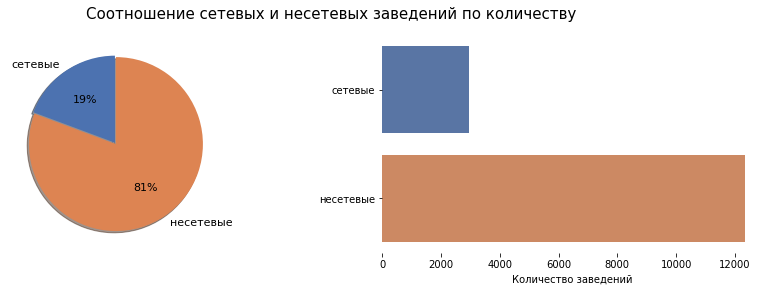

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,4))

fig.suptitle('Соотношение сетевых и несетевых заведений по количеству',fontsize=15)
data = rest_data_group_by_chain['id']
explode = (0.02, 0)
labels = ['сетевые', 'несетевые']
colors = sns.color_palette('deep')[0:2]
ax1.pie(data, 
        labels = labels, 
        colors = colors, 
        autopct='%.0f%%', 
        startangle=90, 
        explode=explode, 
        shadow=True,
        textprops={'fontsize': 11})

ax2 = sns.barplot(x='id', y='chain', data=rest_data_group_by_chain.sort_values(by='id', ascending=True), palette="deep")
ax2 = ax2.set_yticklabels(['сетевые', 'несетевые'])

plt.xlabel('Количество заведений')
plt.ylabel('')
plt.box(False)

plt.show()

### Для какого вида объекта общественного питания характерно сетевое распространение?

Для ответа на этот вопрос сделаем справочную таблицу id по сетевому / несетевому характеру заведения и количеству:

In [19]:
rest_data_chain = rest_data.groupby(['object_type','chain'])['id'].nunique()
rest_data_chain = rest_data_chain.sort_values(ascending=False).reset_index()
print(rest_data_chain)

   object_type chain    id
0   кафе        нет   4675
1   столовая    нет   2576
2   ресторан    нет   1734
3   кафе        да    1387
4   экспресс    нет   1123
5   бар         нет   815 
6   экспресс    да    786 
7   буфет       нет   567 
8   ресторан    да    542 
9   кафетерий   нет   344 
10  закусочная  нет   300 
11  кулинария   нет   194 
12  кулинария   да    78  
13  закусочная  да    56  
14  кафетерий   да    52  
15  бар         да    37  
16  буфет       да    10  
17  столовая    да    3   


Строим график. Подойдет категорийная столбчатая диаграмма:

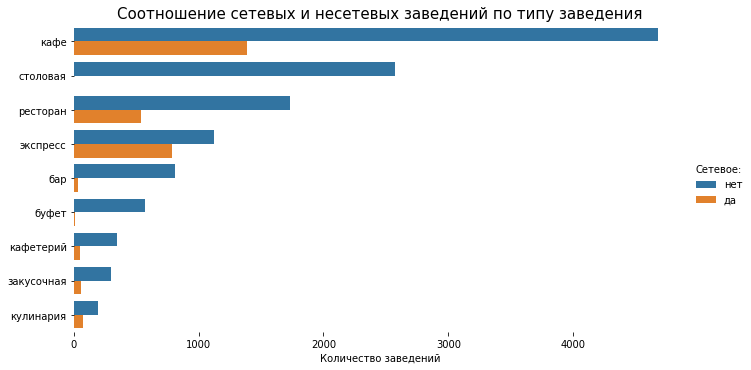

In [20]:
g = sns.factorplot(
    x='id', y='object_type', hue='chain', data=rest_data_chain, kind='bar', height=5, aspect=2)

plt.xlabel('Количество заведений')
plt.ylabel('')
plt.grid(False)
plt.box(False)
g._legend.set_title("Сетевое:")

plt.title('Соотношение сетевых и несетевых заведений по типу заведения',fontsize=15)
plt.show()

**Из расчетов и графика мы видим, что среди сетевых пунктов общественного питания лидируют `кафе и пункты быстрого питания` (экспресс) и `рестораны` и практически отсутствуют `столовые и буфеты`. Для несетевых же особенно характерно кафе, столовые, рестораны.**

**То есть, кафе лидируют в обоих случаях.**

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Для отображения данной информации поможет гистограмма. Сначала отфильтруем данные:

In [21]:
rest_data_chain_seats = rest_data.query('chain == "да"')
rest_data_chain_seats.head()

,id,object_name,chain,object_type,address,number
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,Алло Пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,Суши Wok,да,экспресс,"город Москва, Азовская улица, дом 3",7
18,58565,Тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160


Строим график:

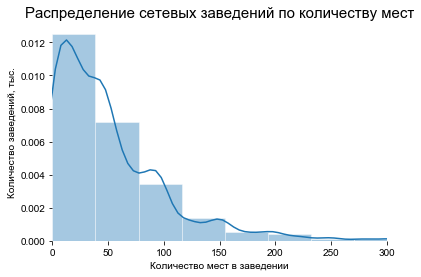

In [22]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.distplot(rest_data_chain_seats['number'], bins=15)
plt.box(False)
plt.grid(False)
ax.set_xlim(0,300)
plt.xlabel('Количество мест в заведении')
plt.ylabel('Количество заведений, тыс.')
plt.title("Распределение сетевых заведений по количеству мест", fontsize='15');

**Как видим из графика, характерно `большее количество заведений с небольшим числом посадочных мест`.**

###  Какой вид объектов общественного питания предоставляет в среднем самое большое количество посадочных мест?

Посчитаем среднее количество посадочных мест по видам объектов общественного питания:

In [23]:
rest_data_group_by_type_mean = rest_data.groupby('object_type')['number'].mean().sort_values(ascending=False).reset_index()

Построим график, в данном случае подойдет столбчатая диаграмма. Поскольку значения сильно разнятся, лучше представить ее в горизонтальном виде:

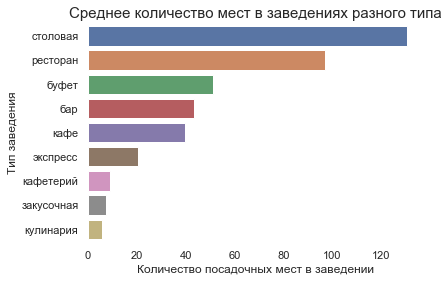

In [24]:
sns.barplot(x='number', y='object_type', data=rest_data_group_by_type_mean, estimator=median)
plt.box(False)
plt.grid(False)
plt.xlabel('Количество посадочных мест в заведении')
plt.ylabel('Тип заведения')
plt.title("Среднее количество мест в заведениях разного типа", fontsize='15');

**Как мы видим, по показателю среднего количества посадочных мест `лидирует категория "столовых"`.**

### Выделите в отдельный столбец информацию об улице из столбца address.

In [25]:
rest_data_street = rest_data.copy()
rest_data_street.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Сначала уберем упоминание города Москва и других замеченных населенных пунктов:

In [26]:
rest_data_street['address'] = rest_data_street['address'].replace(regex=['город Москва,'],value='')
rest_data_street['address'] = rest_data_street['address'].replace(regex=['поселение Московский,'],value='')
rest_data_street['address'] = rest_data_street['address'].replace(regex=['город Зеленоград,'],value='')
rest_data_street['address'] = rest_data_street['address'].replace(regex=['поселение Сосенское,'],value='')
rest_data_street.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"Абрамцевская улица, дом 9, корпус 1",50


Теперь применим lambda функцию для выделения первого фрагмента текста:

In [27]:
rest_data_street['street'] = rest_data_street['address'].apply(lambda x: x.split(",")[0])
rest_data_street.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Проверим уникальность названий: возможно, присутствуют названия, где слово "улица" может быть как в начале, так и в конце:

In [28]:
print(rest_data_street['street'].nunique())

2057


Удалим слово "улица" и некоторые другие похожие названия, проверим количество после изменения:

In [29]:
rest_data_copy_temp = rest_data_street.copy()
rest_data_copy_temp['street'] = rest_data_copy_temp['street'].replace(regex=['улица'],value='')
rest_data_copy_temp['street'] = rest_data_copy_temp['street'].replace(regex=['шоссе'],value='')
rest_data_copy_temp['street'] = rest_data_copy_temp['street'].replace(regex=['переулок'],value='')
rest_data_copy_temp['street'] = rest_data_copy_temp['street'].replace(regex=['проезд'],value='')
rest_data_copy_temp['street'] = rest_data_copy_temp['street'].apply(lambda x: x.strip())
print(rest_data_copy_temp['street'].nunique())

1998


Количество названий уменьшилось, но незначительно, поэтому будем игнорировать вероятность неявных дубликатов и остановимся на файле rest_data_street.

### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [30]:
rest_data_street_top10 = rest_data_street.groupby('street')['id'].count().reset_index()
rest_data_street_top10 = rest_data_street_top10.nlargest(10, 'id').reset_index()
rest_data_street_top10.head(10)

,index,street,id
0,1557,проспект Мира,199
1,1149,Профсоюзная улица,180
2,839,Ленинградский проспект,169
3,1135,Пресненская набережная,165
4,563,Варшавское шоссе,160
5,842,Ленинский проспект,147
6,1554,проспект Вернадского,130
7,756,Каширское шоссе,112
8,830,Кутузовский проспект,112
9,761,Кировоградская улица,107


Построим график. Чтобы наглядно видеть названия улиц, расположим его горизонтально:

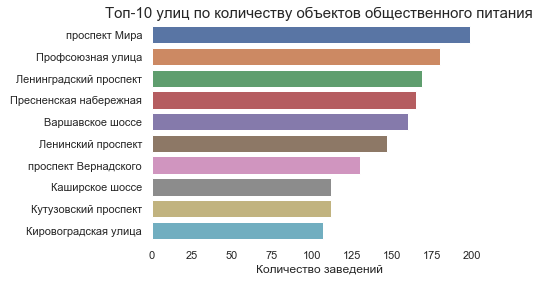

In [31]:
sns.barplot(x='id', y='street', data=rest_data_street_top10)
plt.box(False)
plt.grid(False)
plt.xlabel('Количество заведений')
plt.ylabel('')
plt.title("Топ-10 улиц по количеству объектов общественного питания", fontsize='15');

Для отображения информации по районам импортируем внешние данные:

In [32]:
from io import BytesIO
import requests
spreadsheet_id = '1x0eZI1up1Z3qrzzr3LoCGKTpecPI26X9VhL_bfMcrG0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)
r = requests.get(file_name)
area_df = pd.read_excel(BytesIO(r.content))
area_df.head()

,in_moscow,city,street,simple_address,bldg_type,bldg_number,adm_area,district
0,да,город Москва,Косинская улица,"Косинская улица, дом 26А",дом,26А,Восточный административный округ,муниципальный округ Вешняки
1,да,город Москва,Гороховский переулок,"Гороховский переулок, дом 21",дом,21,Центральный административный округ,муниципальный округ Басманный
2,да,город Москва,Ленинградский проспект,"Ленинградский проспект, дом 73А, строение 3",дом,73А,Северный административный округ,муниципальный округ Сокол
3,да,город Москва,улица Вострухина,"улица Вострухина, дом 5А",дом,5А,Юго-Восточный административный округ,муниципальный округ Рязанский
4,да,город Москва,улица Космонавта Волкова,"улица Космонавта Волкова, дом 10, строение 1",дом,10,Северный административный округ,муниципальный округ Войковский


In [33]:
area_df['street'] = area_df['street'].str.strip()
area_df['simple_address'] = area_df['simple_address'].str.strip()
rest_data_street['street'] = rest_data_street['street'].str.strip()
rest_data_street['address'] = rest_data_street['address'].str.strip()
area_df.head()

,in_moscow,city,street,simple_address,bldg_type,bldg_number,adm_area,district
0,да,город Москва,Косинская улица,"Косинская улица, дом 26А",дом,26А,Восточный административный округ,муниципальный округ Вешняки
1,да,город Москва,Гороховский переулок,"Гороховский переулок, дом 21",дом,21,Центральный административный округ,муниципальный округ Басманный
2,да,город Москва,Ленинградский проспект,"Ленинградский проспект, дом 73А, строение 3",дом,73А,Северный административный округ,муниципальный округ Сокол
3,да,город Москва,улица Вострухина,"улица Вострухина, дом 5А",дом,5А,Юго-Восточный административный округ,муниципальный округ Рязанский
4,да,город Москва,улица Космонавта Волкова,"улица Космонавта Волкова, дом 10, строение 1",дом,10,Северный административный округ,муниципальный округ Войковский


Подцепим базу данных к нашей оригинальной таблице:

In [34]:
rest_data_merged = rest_data_street.copy()
rest_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15279 entries, 0 to 15364
Data columns (total 7 columns):
id             15279 non-null int64
object_name    15279 non-null object
chain          15279 non-null object
object_type    15279 non-null object
address        15279 non-null object
number         15279 non-null int64
street         15279 non-null object
dtypes: int64(2), object(5)
memory usage: 954.9+ KB


In [35]:
rest_data_merged = rest_data_merged.merge(area_df, left_on="address", right_on="simple_address")
rest_data_merged_left = rest_data_merged[['id','object_name','chain','object_type','address','number','street_x','in_moscow','city','adm_area','district']]
rest_data_merged_left.head()

,id,object_name,chain,object_type,address,number,street_x,in_moscow,city,adm_area,district
0,151635,СМЕТАНА,нет,кафе,"улица Егора Абакумова, дом 9",48,улица Егора Абакумова,да,город Москва,Северо-Восточный административный округ,муниципальный округ Ярославский
1,77874,Родник,нет,кафе,"улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,да,город Москва,Центральный административный округ,муниципальный округ Таганский
2,24309,Кафе «Академия»,нет,кафе,"Абельмановская улица, дом 6",95,Абельмановская улица,да,город Москва,Центральный административный округ,муниципальный округ Таганский
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"Абрамцевская улица, дом 1",40,Абрамцевская улица,да,город Москва,Северо-Восточный административный округ,муниципальный округ Лианозово
4,119365,Кафе «Вишневая метель»,нет,кафе,"Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,да,город Москва,Северо-Восточный административный округ,муниципальный округ Лианозово


Оставим только строки, входящие в Топ-10. Сначала создадим предварительный словарь:

In [36]:
data_street_dict = rest_data_merged[['street_x','adm_area','district']].dropna()
data_street_dict.drop_duplicates(inplace=True)
data_street_dict.head(10)

,street_x,adm_area,district
0,улица Егора Абакумова,Северо-Восточный административный округ,муниципальный округ Ярославский
1,улица Талалихина,Центральный административный округ,муниципальный округ Таганский
2,Абельмановская улица,Центральный административный округ,муниципальный округ Таганский
3,Абрамцевская улица,Северо-Восточный административный округ,муниципальный округ Лианозово
7,переулок Сивцев Вражек,Центральный административный округ,муниципальный округ Арбат
8,Авиамоторная улица,Юго-Восточный административный округ,муниципальный округ Лефортово
14,улица Авиаторов,Западный административный округ,муниципальный округ Солнцево
17,Азовская улица,Юго-Западный административный округ,муниципальный округ Зюзино
20,Большая Академическая улица,Северный административный округ,муниципальный округ Коптево
21,Филипповский переулок,Центральный административный округ,муниципальный округ Арбат


Теперь подгрузим данные из словаря в таблицу Топ-10:

In [37]:
data_street_dict['street_x'] = data_street_dict['street_x'].str.strip()
data_street_dict['adm_area'] = data_street_dict['adm_area'].str.strip()
data_street_dict['district'] = data_street_dict['district'].str.strip()
rest_data_street_top10['street'] = rest_data_street_top10['street'].str.strip()
data_street_dict.drop_duplicates(inplace=True)
rest_data_street_top10.drop_duplicates(inplace=True)

data_street_dict_updated = data_street_dict.drop_duplicates(subset=['street_x','district','adm_area']).groupby(['street_x']).agg(
    {'adm_area' : lambda x: ', '.join(set(x)),
     'district' : lambda x: ', '.join(x)}).reset_index()

rest_data_street_updated = rest_data_street_top10.merge(data_street_dict_updated, left_on="street", right_on="street_x")
rest_data_street_updated.drop_duplicates(inplace=True)
rest_data_street_updated = rest_data_street_updated.drop(['index','street_x'], 1)
rest_data_street_updated.columns=[['улица','кол-во заведений','округ', 'район']]
rest_data_street_updated = rest_data_street_updated[['улица','кол-во заведений','район','округ']]
rest_data_street_updated.head(10)

,улица,кол-во заведений,район,округ
0,проспект Мира,199,"муниципальный округ Мещанский, муниципальный округ Останкинский, муниципальный округ Алексеевский, муниципальный округ Ростокино, муниципальный округ Свиблово, муниципальный округ Ярославский","Центральный административный округ, Северо-Восточный административный округ"
1,Профсоюзная улица,180,"муниципальный округ Академический, муниципальный округ Черемушки, муниципальный округ Обручевский, муниципальный округ Коньково, муниципальный округ Теплый Стан, муниципальный округ Ясенево",Юго-Западный административный округ
2,Ленинградский проспект,169,"муниципальный округ Беговой, муниципальный округ Аэропорт, муниципальный округ Сокол, муниципальный округ Хорошевский",Северный административный округ
3,Пресненская набережная,165,муниципальный округ Пресненский,Центральный административный округ
4,Варшавское шоссе,160,"муниципальный округ Донской, муниципальный округ Нагорный, муниципальный округ Чертаново Южное, муниципальный округ Чертаново Северное, муниципальный округ Чертаново Центральное, муниципальный округ Нагатино-Садовники, муниципальный округ Южное Бутово","Южный административный округ, Юго-Западный административный округ"
5,Ленинский проспект,147,"муниципальный округ Якиманка, муниципальный округ Донской, муниципальный округ Гагаринский, муниципальный округ Ломоносовский, муниципальный округ Обручевский, муниципальный округ Тропарево-Никулино, муниципальный округ Теплый Стан, муниципальный округ Проспект Вернадского","Западный административный округ, Центральный административный округ, Юго-Западный административный округ, Южный административный округ"
6,проспект Вернадского,130,"муниципальный округ Гагаринский, муниципальный округ Ломоносовский, муниципальный округ Проспект Вернадского, муниципальный округ Тропарево-Никулино, муниципальный округ Раменки","Западный административный округ, Юго-Западный административный округ"
7,Каширское шоссе,112,"муниципальный округ Нагатино-Садовники, муниципальный округ Москворечье-Сабурово, муниципальный округ Орехово-Борисово Южное, муниципальный округ Орехово-Борисово Северное",Южный административный округ
8,Кутузовский проспект,112,"муниципальный округ Фили-Давыдково, муниципальный округ Дорогомилово",Западный административный округ
9,Кировоградская улица,107,"муниципальный округ Чертаново Центральное, муниципальный округ Чертаново Южное, муниципальный округ Чертаново Северное",Южный административный округ


**Мы получили таблицу районов и ответили на вопрос, в каких районах Москвы находятся эти улицы.**

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Составим сводную таблицу по районам, с количеством объектов на улице, равным 1:

In [38]:
rest_data_merged_one = rest_data_merged_left.copy()
rest_data_merged_one = rest_data_merged_one[['district', 'adm_area','street_x', 'id']]
rest_data_street_one_final = rest_data_merged_one.groupby(['district', 'adm_area','street_x'])['id'].count().reset_index()
rest_data_street_one_final = rest_data_street_one_final.query('id == 1')
rest_data_street_one_final.head()

,district,adm_area,street_x,id
13,муниципальный округ Алексеевский,Северо-Восточный административный округ,1-й Рижский переулок,1
17,муниципальный округ Алексеевский,Северо-Восточный административный округ,Зубарев переулок,1
18,муниципальный округ Алексеевский,Северо-Восточный административный округ,Кулаков переулок,1
19,муниципальный округ Алексеевский,Северо-Восточный административный округ,Кучин переулок,1
22,муниципальный округ Алексеевский,Северо-Восточный административный округ,Рижский проезд,1


Теперь сгруппируем таблицу по районам:

In [39]:
rest_data_street_one_group = rest_data_street_one_final.groupby(['district', 'adm_area'])['street_x'].count().sort_values(ascending=False).reset_index()
rest_data_street_one_group.head()

,district,adm_area,street_x
0,муниципальный округ Таганский,Центральный административный округ,28
1,муниципальный округ Басманный,Центральный административный округ,27
2,муниципальный округ Хамовники,Центральный административный округ,27
3,муниципальный округ Тверской,Центральный административный округ,23
4,муниципальный округ Пресненский,Центральный административный округ,21


Отразим эти данные на графике:

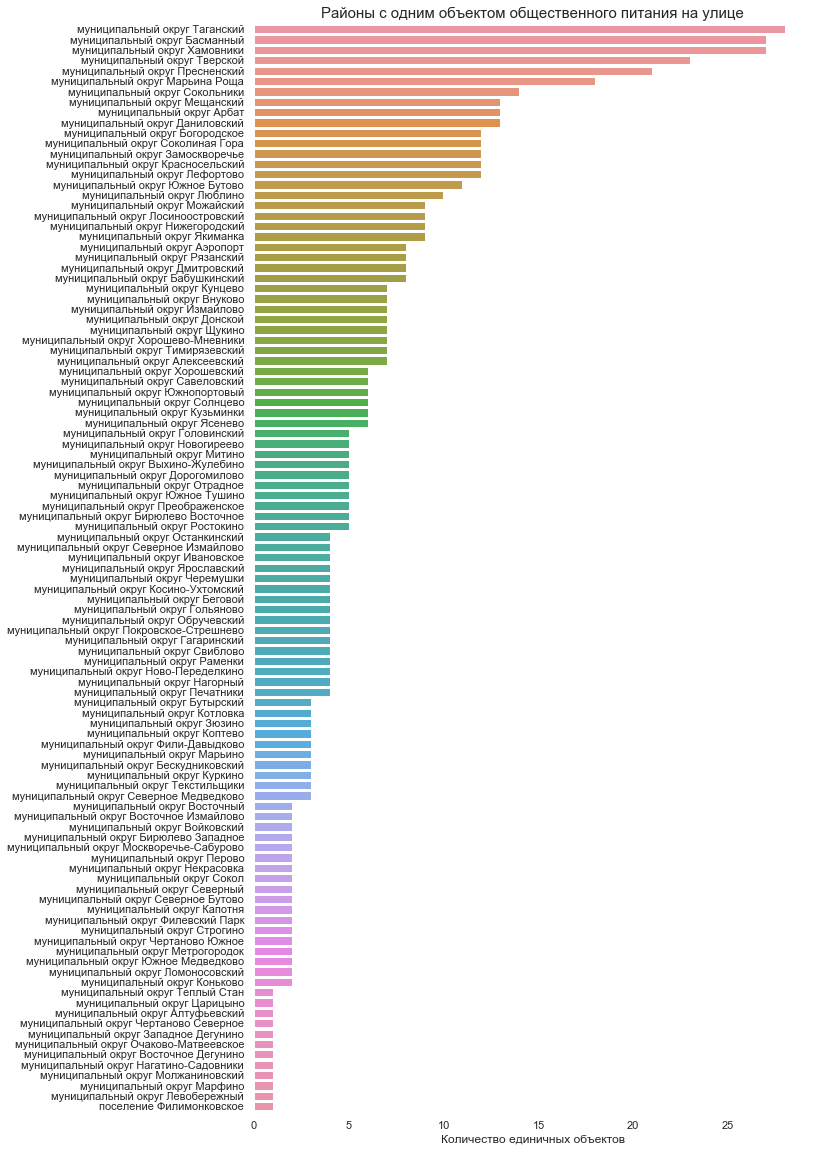

In [40]:
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.barplot(x='street_x', y='district', data=rest_data_street_one_group)
plt.box(False)
plt.grid(False)
plt.xlabel('Количество единичных объектов')
plt.ylabel('')
plt.title("Районы с одним объектом общественного питания на улице", fontsize='15');

Такой же график по округам:

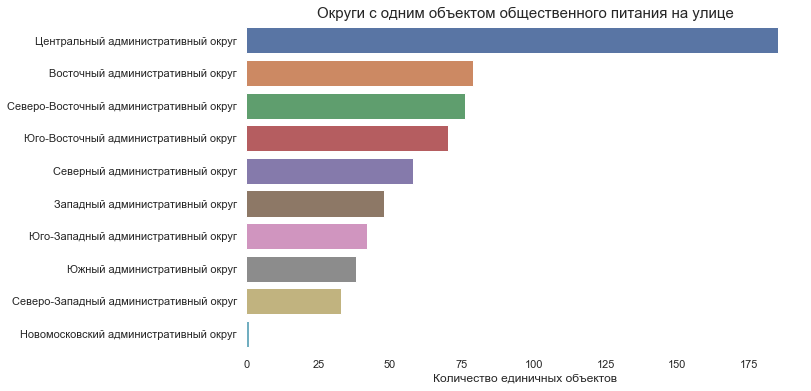

In [41]:
rest_data_street_one_group = rest_data_street_one_final.groupby(['adm_area'])['street_x'].count().sort_values(ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='street_x', y='adm_area', data=rest_data_street_one_group, ci = None)
plt.box(False)
plt.grid(False)
plt.xlabel('Количество единичных объектов')
plt.ylabel('')
plt.title("Округи с одним объектом общественного питания на улице", fontsize='15');

**Мы получили таблицу районов и ответили на вопрос, в каких районах Москвы находятся эти улицы.**

### Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

Для отслеживания закономерностей построим график методом jointplot() с указанием регрессии. Подготовим таблицу с данными:

In [42]:
rest_data_street_top = (rest_data_street.groupby(['street']).agg(
    {'id': 'count', 'number': 'mean'})).sort_values(by='id', ascending=False).reset_index()
rest_data_street_top.head(10)

,street,id,number
0,проспект Мира,199,62.085427
1,Профсоюзная улица,181,47.773481
2,Ленинградский проспект,171,52.497076
3,Пресненская набережная,165,45.975758
4,Варшавское шоссе,161,53.000000
5,Ленинский проспект,148,63.148649
6,проспект Вернадского,130,67.915385
7,Кутузовский проспект,112,86.580357
8,Каширское шоссе,112,55.098214
9,Кировоградская улица,107,60.065421


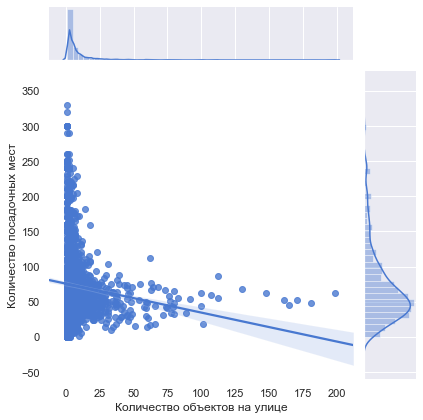

In [43]:
sns.set_palette('muted')
sns.jointplot(x='id', y='number', data=rest_data_street_top, kind="reg")
plt.xlabel('Количество объектов на улице')
plt.ylabel('Количество посадочных мест')
plt.box(False)
plt.grid(False)

`Для презентации руководству и инвесторам больше подойдет данный вид схемы:`

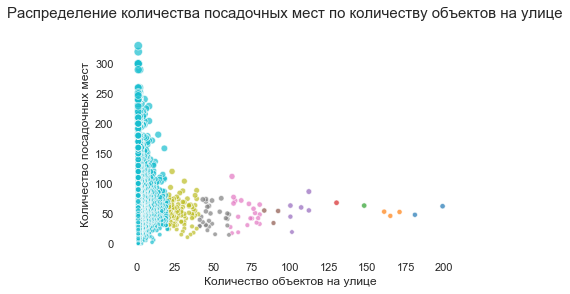

In [44]:
sns.scatterplot(x='id', y='number', 
                data=rest_data_street_top, size='number', hue='id', legend=False, 
                palette='tab10_r', alpha=0.7)
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('Количество объектов на улице')
plt.ylabel('Количество посадочных мест')
plt.box(False)
plt.grid(False)
plt.suptitle("Распределение количества посадочных мест по количеству объектов на улице", fontsize='15');

- **Из распределения мы видим, что чем больше объектов на улице, тем меньшее количество посадочных мест в заведениях в среднем.**
- **Сначала количество мест уменьшается в прогрессии, но после порога в 100 объектов остается неизменным.**
- **В среднем, на самых "проходных" улицах количество посадочных мест практически одинаково, и оно не превышает 100 мест**

# 3. Выводы и рекомендации <a class="anchor" id="third-bullet"></a>

Изучив представленные данные мы можем обратить внимание на следующие выводы:

- На рынке установились тенденции. Допустим, количество посадочных мест на самых проходных улицах остается постоянным. Если заказчик планирует открывать кафе на одной из таких оживленных улиц, следует учитывать этот порог;
- Заведение типа "кафе" занимает самую большую долю рынка - 40%, следом идут категории столовых, ресторанов и объектов быстрого питания в примерно равных пропорциях;
- Сетевых заведений в Москве в 4 раза меньше, чем несетевых, при этом кафе характерны для обоих типов, а столовые, буфеты, бары, кафетерии для сетевых объектов очень немногочисленны;
- В Москве гораздо больше заведений с небольшим количеством мест, заведения до 50 мест особенно массовы (буфет, бар, кафе в среднем имеют такое количество мест);
- Топ-10 улиц по количеству заведений указаны на диаграмме, самые непопулярные районы также указаны.


**Рекомендации:**
- Очевидно, самую большую популярность на рынке имеют кафе, то есть робокафе вполне может вписаться в эту нишу;
- Из сетевых заведений на рынке устойчивы кафе, пункты быстрого питания и рестораны, среди несетевых лидируют кафе, столовые, рестораны. То есть, кафе популярно в обоих случаях.
- По тенденциям видно, что бизнес не спешит открывать сетевые заведения, более популярны и оправданны несетевые заведения;
- Заведения с небольшим количеством мест особенно массовы, следует выбрать размер около 40-50 посадочных мест.Заказчику необходимо учитывать такую пропускную способность для расчета окупаемости;
- Следует сконцентрироваться на районах из Топ-10 и избегать районов с большим количеством единичных объектов на улицах (список прилагается).

**Презентация**: <https://disk.yandex.ru/i/duQSQ_1dA-Z6Cg> 